# KNN을 활용한 대출 승인 예측 및 최적 이웃 수 탐색 실습

In [78]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from itertools import compress

In [85]:
# 데이터 불러오기
url = 'https://raw.githubusercontent.com/ykkim77/bigdata_analysis_basic_11th/main/Personal_Loan.csv'
ploan = pd.read_csv(url)

ploan.head(60) # 데이터 예시 확인

,Unnamed: 0,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,4,35,8,45,4,1.0,2,0,0,0,0,0,1
5,5,37,13,29,4,0.4,2,155,0,0,0,1,0
6,6,53,27,72,2,1.5,2,0,0,0,0,1,0
7,7,50,24,22,1,0.3,3,0,0,0,0,0,1
8,8,35,10,81,3,0.6,2,104,0,0,0,1,0
9,9,34,9,180,1,8.9,3,0,1,0,0,0,0


In [80]:
ploan.shape # 데이터 차원 확인

(2500, 13)

In [ ]:
# 수치형, 범주형, 이진형 변수 구분
numeric_features = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']
categorical_features = ['Education', 'Family']
binary_features = ['Securities Account', 'CD Account', 'Online','CreditCard']
target = 'Personal Loan'


## 데이터 전처리

```
[0.2, 0.7, 0.05]  ← 수치형 정규화 결과
[1, 0, 1, 0, 0]   ← 이진형 그대로 사용

Education	Education_1	  Education_2	  Education_3
1	             1	          0	               0
2	             0	          1	               0
3	             0	          0	               1         ← 범주형 변수는 원핫인코딩
```

In [51]:
# 수치형 정규화
scaler = MinMaxScaler()
numeric_scaled = scaler.fit_transform(ploan[numeric_features])
numeric_scaled_df = pd.DataFrame(numeric_scaled, columns=numeric_features)

# 범주형 원핫 인코딩
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_encoded = encoder.fit_transform(ploan[categorical_features])
categorical_encoded_df = pd.DataFrame(
    categorical_encoded,
    columns=encoder.get_feature_names_out(categorical_features)
)

# 이진형 변수는 그대로 사용
binary_df = ploan[binary_features].reset_index(drop=True)

In [69]:
# X 데이터 병합
X = pd.concat([numeric_scaled_df, categorical_encoded_df, binary_df], axis=1)
y = ploan[target]

In [53]:
# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)


In [ ]:
# k값 변화에 따른 정확도 비교
training_accuracy = []
test_accuracy = []
neighbors_settings = range(1, 25)  # 실험할 이웃 수(k)의 범위 설정: 1부터 24까지

for n_neighbors in neighbors_settings:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)  # KNN 분류기 생성 (현재 이웃 수 k로 설정)
    clf.fit(X_train, y_train)  # 모델을 훈련 데이터에 적합 (학습)
    training_accuracy.append(clf.score(X_train, y_train))  # 학습 데이터에 대한 정확도를 리스트에 저장
    test_accuracy.append(clf.score(X_test, y_test)) # 테스트 데이터에 대한 정확도를 리스트에 저장

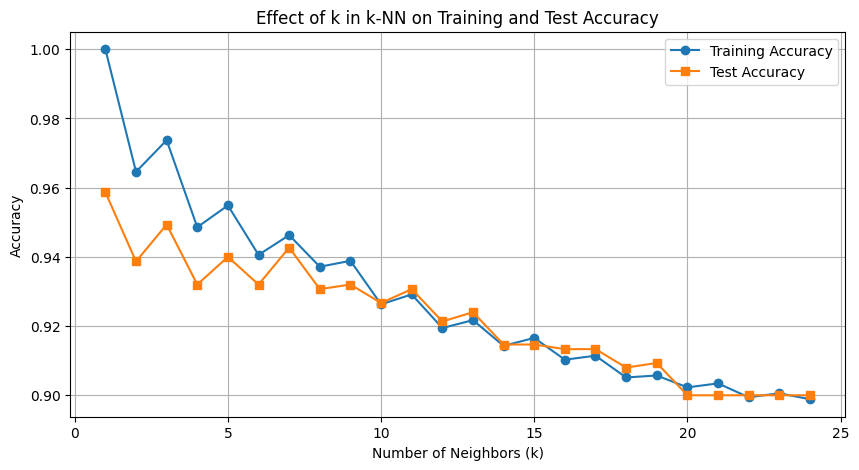

In [77]:
# 정확도 시각화
plt.figure(figsize=(10, 5))
plt.plot(neighbors_settings, training_accuracy, label="Training Accuracy", marker='o')
plt.plot(neighbors_settings, test_accuracy, label="Test Accuracy", marker='s')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("Effect of k in k-NN on Training and Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 최적의 k 찾기
test_accuracy = np.array(test_accuracy)  # 테스트 정확도 리스트를 넘파이 배열로 변환 (논리 연산 처리를 위함)
best_idx = test_accuracy == np.max(test_accuracy)  # 테스트 정확도가 최대값인 위치(True/False 리스트) 생성
best_n = list(compress(neighbors_settings, best_idx)) # neighbors_settings와 best_idx를 압축하여 최대 정확도를 주는 k값만 추출

print('Best neighbors:', best_n[0]) # 가장 첫 번째 최적 k값을 출력


Best neighbors: 1


In [ ]:
# 최적 모델 학습 및 예측
best_k = best_n[0]  # 최적의 k 값(best_n 리스트에서 첫 번째 값)을 변수에 저장
best_clf = KNeighborsClassifier(n_neighbors=best_k)  # 최적의 k를 사용하여 k-NN 분류기 객체 생성
best_clf.fit(X_train, y_train) # 최적의 k-NN 분류기를 학습 데이터로 학습시킴

KNeighborsClassifier(n_neighbors=1)

In [ ]:
train_pred_y = best_clf.predict(X_train)  # 학습 데이터에 대한 예측 수행 (모델이 얼마나 학습 데이터에 잘 맞는지 확인)
test_pred_y = best_clf.predict(X_test)  # 테스트 데이터에 대한 예측 수행 (일반화 성능 확인)

# 성능 출력
tmp_acc = accuracy_score(y_test, test_pred_y) # 테스트 데이터에 대한 정확도(accuracy)를 계산
print("Best K is {}".format(best_k), ", Test accuracy: {:.4f}".format(tmp_acc))  

Best K is 1 , Test accuracy: 0.9587


In [ ]:
# 혼돈행렬 및 정확도 출력
print(f'\n 학습 혼동행렬:\n{confusion_matrix(y_train, train_pred_y)}')
print(f'\n 테스트 혼동행렬:\n{confusion_matrix(y_test, test_pred_y)}')
print(f'\n 학습 정확도: {accuracy_score(y_train, train_pred_y):.4f}')
print(f' 테스트 정확도: {accuracy_score(y_test, test_pred_y):.4f}')


 학습 혼동행렬:
[[1571    0]
 [   0  179]]

 테스트 혼동행렬:
[[663  10]
 [ 21  56]]

 학습 정확도: 1.0000
 테스트 정확도: 0.9587


## Confusion Matrix 시각화

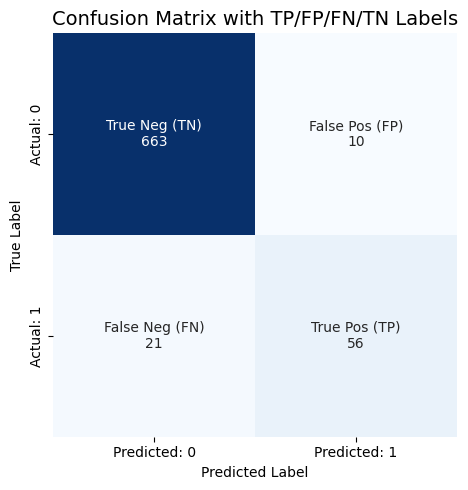

 Precision (정밀도): 0.8485
 Recall (재현율): 0.7273
 F1 Score: 0.7832


In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# 혼동 행렬 계산 (예: 테스트 데이터 기준)
cm = confusion_matrix(y_test, test_pred_y)

# 혼동 행렬 내 값을 순서대로 꺼내서 이름과 함께 표시 (TN, FP, FN, TP)
group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
group_counts = [f"{value:}" for value in cm.flatten()]  # 각 셀의 숫자
labels = [f"{name}\n{count}" for name, count in zip(group_names, group_counts)]
labels = np.array(labels).reshape(2, 2)

# 혼동 행렬 시각화 (TP, FP, FN, TN 레이블 포함)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, square=True,
            xticklabels=['Predicted: 0', 'Predicted: 1'],
            yticklabels=['Actual: 0', 'Actual: 1'])

plt.title("Confusion Matrix with TP/FP/FN/TN Labels", fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ----------------------------------------------------
# 분류 성능 지표 계산 및 출력
# ----------------------------------------------------

# 정밀도(Precision): 모델이 대출하라고 예측한 사람 중 실제로 필요한 사람의 비율
precision = precision_score(y_test, test_pred_y)

# 재현율(Recall): 실제로 대출이 필요한 사람 중 모델이 대출하라고 예측한 비율
recall = recall_score(y_test, test_pred_y)

# F1 Score: Precision과 Recall의 조화 평균
f1 = f1_score(y_test, test_pred_y)

# 결과 출력
print(f" Precision (정밀도): {precision:.4f}")
print(f" Recall (재현율): {recall:.4f}")
print(f" F1 Score: {f1:.4f}")
